In [1]:
# Import libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Import ML libs
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, f1_score, plot_precision_recall_curve, recall_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

#import bootstrap libs
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline, Pipeline

#dummy classifier
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier

In [2]:
# Load data
train_merged = pd.read_csv('./data/train_street_merged.csv')
test_merged = pd.read_csv('./data/test_street_merged.csv')
submission = pd.read_csv('./data/sampleSubmission.csv')

In [3]:
train_merged.head(1)

,date,latitude,longitude,nummosquitos,wnvpresent,street_ W ARMITAGE AVENUE,street_ E 105TH ST,street_ E 111TH ST,street_ E 115TH ST,street_ E 118TH ST,...,coolsq,preciptotalsq,resultspeedsq,resultdirsq,avgspeedsq,daylightminssq,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_OTHERS
0,2007-05-29,41.95469,-87.800991,1,0,0,0,0,0,0,...,81.0,0.0,33.64,324.0,42.25,802816.0,0,1,0,0


## Baseline Model

In [4]:
#define X, y
X = train_merged.drop(columns = ['wnvpresent','date','nummosquitos'])
y = train_merged['wnvpresent']

In [5]:
baseline = y.value_counts(normalize=True)

In [6]:
print(f'Imbalanced Data Baseline Accuracy: {baseline[0].round(3)}%')

Imbalanced Data Baseline Accuracy: 0.947%


In [7]:
print(f"Balanced Data Baseline Accuracy: 0.5%")

Balanced Data Baseline Accuracy: 0.5%


## Train Test Split

In [8]:
#split train test 
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y)

## Pipeline

Pipeline with oversampling bootstrapping (SMOTE). Metric is using recall as we are trying to identify the true positive rate. 

In this scenario, the identification of the true cases (WNV Present) to the False Negative (Type II error where predicted to be not present proved to be otherwise) in order to better naviagte resources to the location for pesticide control.

### Logistic Regression

In [9]:
#Instantiate pipeline 
pipe = Pipeline([
    ('ss' , StandardScaler()),
    ('oversample', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(random_state=42, max_iter=10000))
])

#set pipe params
pipe_params = {
    'logreg__solver' : ['liblinear','lbfgs'],
    'logreg__C': np.logspace(-2, 1, 1),
    'logreg__class_weight':["balanced",]
}

#gridsearch
gs = GridSearchCV(pipe, pipe_params,  cv=5,n_jobs=-1, scoring='recall')
#fit model
gs.fit(X_train, y_train)
best_logreg = gs.best_estimator_

print('Training Recall: ', best_logreg.score(X_train, y_train))
print('Testing Recall: ', best_logreg.score(X_test, y_test))
print('\n')
gs.best_params_

Training Recall:  0.7401715968754001
Testing Recall:  0.7123655913978495




{'logreg__C': 0.01,
 'logreg__class_weight': 'balanced',
 'logreg__solver': 'liblinear'}

### K Nearest Neighbours

In [10]:
#Instantiate pipeline
pipe = Pipeline([
    ('ss' , StandardScaler()),
    ('oversample', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier())
])

#set pipe params
pipe_params = {
    'knn__n_neighbors' : [3,5,7,10],
    'knn__weights' : ['uniform','distance'],
    'knn__p': [1,2]
}
#grid search
gs = GridSearchCV(pipe, pipe_params, cv=5 ,n_jobs=-1, scoring='recall')
#fit model
gs.fit(X_train, y_train)
best_knn = gs.best_estimator_

print('Training Recall: ', best_knn.score(X_train, y_train))
print('Testing Recall: ', best_knn.score(X_test, y_test))
print('\n')
gs.best_params_

Training Recall:  0.851581508515815
Testing Recall:  0.7795698924731183




{'knn__n_neighbors': 7, 'knn__p': 2, 'knn__weights': 'uniform'}

### Random Forest

In [11]:
#Instantiate pipeline
pipe = Pipeline([
    ('ss' , StandardScaler()),
    ('oversample', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42, bootstrap=True))
])

#set pipe params
pipe_params = {
    'rf__n_estimators': [100,150,250],
    'rf__max_depth': [1,3,9,10]
}
#grid search
gs = GridSearchCV(pipe, pipe_params, cv=5 ,n_jobs=-1, scoring='roc_auc')
#fit model
gs.fit(X_train, y_train)
best_rf = gs.best_estimator_

print('Training Accuracy: ', best_rf.score(X_train, y_train))
print('Testing Accuracy: ', best_rf.score(X_test, y_test))
print('\n')
gs.best_params_

Training Accuracy:  0.86771673709822
Testing Accuracy:  0.8640552995391705




{'rf__max_depth': 10, 'rf__n_estimators': 100}

In [12]:
#display result in dataframe
model_df = pd.DataFrame({
    'Model' :['Balanced Baseline','Logistic Regression','K Nearest Neighbors','Random Forest'],
    'Training Recall' : [0.5, best_logreg.score(X_train, y_train),best_knn.score(X_train, y_train),best_rf.score(X_train, y_train)],
    'Test Recall' : [0.5 ,best_logreg.score(X_test, y_test),best_knn.score(X_test, y_test),best_rf.score(X_test, y_test)]
})

model_df

,Model,Training Recall,Test Recall
0,Balanced Baseline,0.500000,0.500000
1,Logistic Regression,0.740172,0.712366
2,K Nearest Neighbors,0.851582,0.779570
3,Random Forest,0.867717,0.864055


## Model Selection

Based on the training and test set recall score, the best model with the best score is .... (RF for now)

In [13]:
#model selection and prediction for validation 
best_model = best_rf
best_model.fit(X_train,y_train)

#predict all datasets
y_preds = best_model.predict(X)

In [14]:
#compare ytest and prediction
pred_df = pd.DataFrame({'true_values': y,
                        'preds_values': y_preds})

pred_df.head()

,true_values,preds_values
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


### F1 Score

In [15]:
f1_score(y, y_preds)

0.3177570093457944

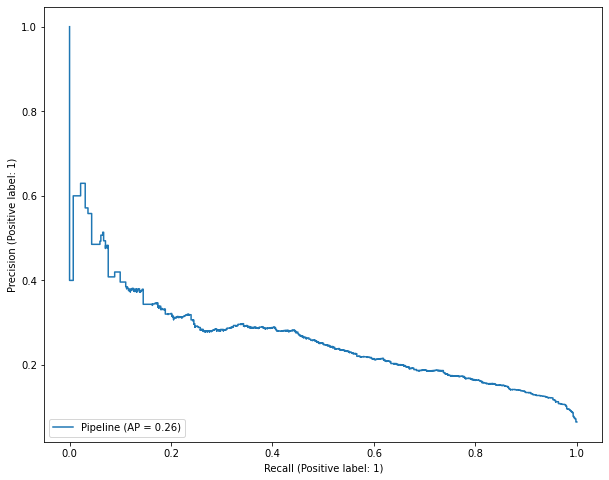

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_precision_recall_curve(best_model,X,y,ax=ax)
plt.show()

## Model Evaluation

### Confusion Matrix

In [17]:
#plot cm to check for prediction accuracy
cm = confusion_matrix(y,y_preds)

In [18]:
tn,fp,fn,tp = confusion_matrix(y, y_preds).ravel()

In [19]:
print(f'True Negatives: {tn}') #predict absent is absent
print(f'False Positives: {fp}') #predict present but absent
print(f'False Negatives: {fn}') #predict absent but present
print(f'True Positives: {tp}') #predict present is present

True Negatives: 8703
False Positives: 1159
False Negatives: 228
True Positives: 323


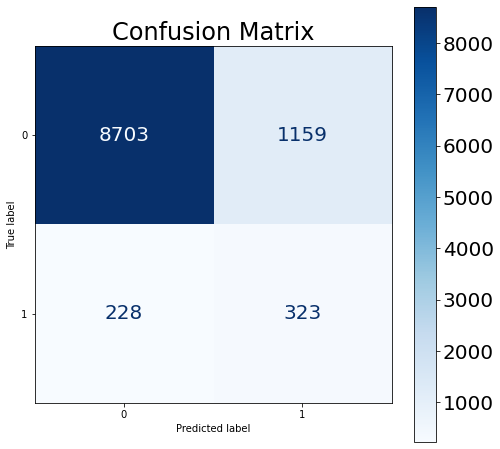

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.rcParams.update({'font.size': 20})
plot_confusion_matrix(best_model, X, y, cmap= 'Blues', 
                  values_format='d', ax=ax );
plt.title('Confusion Matrix')
plt.show()

*Confusion matrix plotted for Predicted and True Values for Class 1 (WNV Present) to Class 0 (No WNV Present) demonstrates the specificity and sensitivity of the model.*

In [21]:
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp/(fp+tp)

In [22]:
print("Sensitivity: ", round(sensitivity,2))
print("Specificity: ", round(specificity,2))
print("Precision:", round(precision,2))

Sensitivity:  0.59
Specificity:  0.88
Precision: 0.22


In this problem statement, the concern on the model prediction will be the false negative, also known as Type II error. With specificity/ recall at 0.89, and sensitivity at 0.78 the model is able to identify the true positive rate and true negative rate accordingly.

However, the precision score is low at 0.29 only. This means the model has been predicting cases as positive more than it should have been. 

### ROC AUC

In [23]:
TPR = sensitivity
print("True Positive Rate: ", round(TPR,2))
TNR = 1 - specificity
print("True Negative Rate (False Positive Rate)", round(TNR,2))

True Positive Rate:  0.59
True Negative Rate (False Positive Rate) 0.12


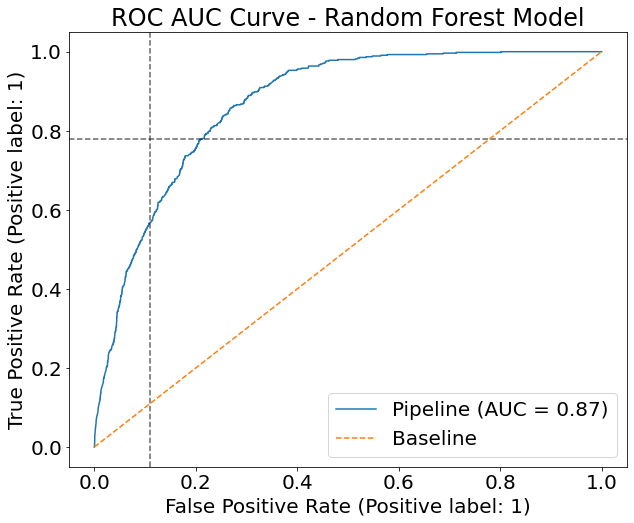

In [24]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_roc_curve(best_model,X,y,ax=ax)
plt.axvline(0.11, color='k',linestyle='--',alpha=0.6)
plt.axhline(0.78, color='k',linestyle='--',alpha=0.6)
plt.plot([0,1],[0,1], color='tab:orange', linestyle='--', label='Baseline')

plt.title('ROC AUC Curve - Random Forest Model')
plt.legend()
plt.show()

### Model Threshold Adjustment

In [25]:
#y_test vs predict proba
pred_prob_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs': best_model.predict_proba(X_test)[:,1]})

pred_prob_df.head()

,true_values,pred_probs
4459,0,0.073130
4099,0,0.004542
4423,0,0.026527
521,0,0.029682
10393,0,0.224347


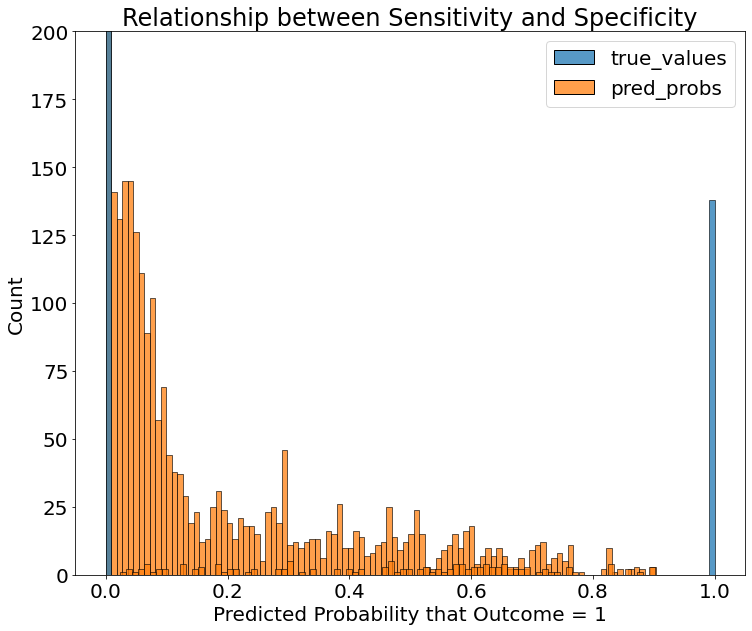

In [26]:
plt.figure(figsize = (12, 10))

# plot distributions of predicted probabilities by actual values
for group in pred_prob_df.groupby('true_values'):
    sns.histplot(group[1], kde = False, bins = 100)

plt.xlabel('Predicted Probability that Outcome = 1')
plt.title('Relationship between Sensitivity and Specificity')
plt.ylim(0,200)
plt.show()

In [27]:
def get_predictions(probabilities, threshold):
    return [0 if prob < threshold else 1 for prob in probabilities]

In [28]:
threshold_list = [0.45, 0.5, 0.55, 0.6]

for threshold in threshold_list:
    preds = get_predictions(best_model.predict_proba(X_test)[:,1], threshold)
    rec = recall_score(y_test, preds)
    prec = precision_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    print(f'Threshold: {threshold:.2f}, Recall: {rec:.2f}, Precision: {prec:.2f}, f1 : {f1:.2f}')

Threshold: 0.45, Recall: 0.60, Precision: 0.18, f1 : 0.28
Threshold: 0.50, Recall: 0.51, Precision: 0.20, f1 : 0.28
Threshold: 0.55, Recall: 0.45, Precision: 0.21, f1 : 0.29
Threshold: 0.60, Recall: 0.36, Precision: 0.23, f1 : 0.28


In [29]:
best_rf

Pipeline(steps=[('ss', StandardScaler()),
                ('oversample', SMOTE(random_state=42)),
                ('rf', RandomForestClassifier(max_depth=10, random_state=42))])

In [30]:
# Extracting feature importances
rf = RandomForestClassifier(max_depth=15, n_estimators=150)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, n_estimators=150)

In [31]:
rf.feature_importances_

array([8.64608965e-02, 9.80327104e-02, 5.27882282e-03, 3.02463741e-03,
       7.93591514e-04, 8.63913743e-04, 2.34904259e-03, 6.24914926e-03,
       9.42260980e-04, 3.95349767e-03, 3.90430969e-03, 2.74629210e-03,
       5.78953056e-06, 1.82166633e-03, 6.46889712e-04, 1.13622326e-03,
       3.09984726e-04, 1.99319274e-05, 2.53683363e-03, 4.22695527e-03,
       5.64214624e-03, 2.97021756e-03, 5.47198514e-03, 2.86962001e-03,
       1.42416491e-03, 8.63762777e-03, 2.17157286e-03, 2.24549127e-03,
       9.83896703e-05, 1.69612593e-04, 1.60212155e-03, 1.26032318e-02,
       7.87552582e-03, 9.39940737e-03, 1.59992496e-02, 1.47514579e-04,
       6.87441660e-03, 7.60213592e-03, 8.48637611e-03, 6.26990171e-05,
       5.47665989e-04, 2.01704989e-03, 5.49894592e-03, 3.39879326e-05,
       3.84191728e-05, 2.33135008e-05, 6.17974572e-03, 2.92701642e-03,
       3.99596458e-03, 1.72488297e-04, 1.59650432e-03, 1.21859657e-03,
       2.52821665e-03, 3.39003902e-05, 3.45009662e-03, 3.75225831e-03,
      

In [32]:
df_fi = pd.DataFrame(zip(X.columns, rf.feature_importances_))

In [33]:
df_fi.head()

,0,1
0,latitude,0.086461
1,longitude,0.098033
2,street_ W ARMITAGE AVENUE,0.005279
3,street_ E 105TH ST,0.003025
4,street_ E 111TH ST,0.000794


In [42]:
df_fi.sort_values(by = 1, ascending = False).head(40)

,0,1
1,longitude,0.098033
0,latitude,0.086461
158,species_CULEX PIPIENS/RESTUANS,0.052204
157,species_CULEX PIPIENS,0.046333
156,daylightminssq,0.035871
144,daylightmins,0.029377
159,species_CULEX RESTUANS,0.029280
123,street_ W OHARE AIRPORT,0.016536
130,tmax,0.016354
34,street_ N OAK PARK AVE,0.015999


In [35]:
X_test = test_merged[X.columns]

In [36]:
kaggle_score = pd.DataFrame(zip(test_merged.id, gs.predict(X_test)))

In [37]:
kaggle_score.rename(columns = {0:"Id", 1: "WnvPresent"}, inplace = True)

In [38]:
kaggle_score.to_csv('./data/submission_3_street.csv', index= False)